# Computing the core Čech and the alpha-core bifiltration along a line

In this notebook, we show how to compute the persistent homology of the core Čech and the alpha-core bfiltrations along the line passing through `(0, max_k)` and `(max_r, 0)`.

In [1]:
import math
import gudhi
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from miniball import Miniball
from scipy.spatial import KDTree

from datasets import sample_circle, sample_rectangle

import warnings
warnings.filterwarnings('ignore')

In [2]:
rng = np.random.default_rng(seed=0)

## Core Čech

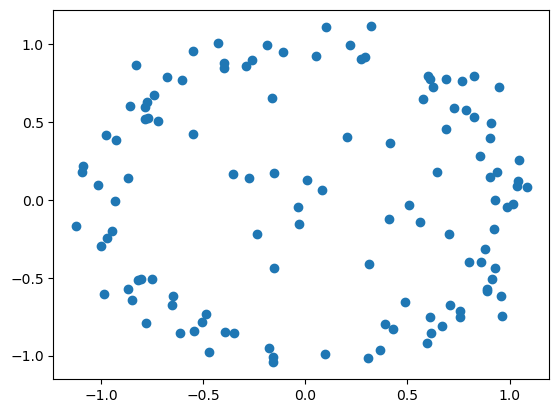

In [3]:
N = 80
M = 40
Z = sample_circle(N, rng, variance=0.005)
Y = sample_rectangle(M, rng)
X = np.r_[Z, Y]
plt.scatter(*X.T)
plt.show()

In [4]:
def core_cech_slope(points, max_dim, max_k, max_r):
    kd_tree = KDTree(points)
    k_core_distances, _ = kd_tree.query(points, k=max_k) 
    line = np.linspace(max_r, 0, num=max_k)
    if max_k>1:
        vertex_indices = np.argmax(line <= k_core_distances, axis=1)
        vertex_values = k_core_distances[np.arange(len(k_core_distances)), vertex_indices]
    else:
        vertex_values = np.array(k_core_distances)
    st = gudhi.SimplexTree()
    for dim in range(max_dim + 1):
        for face in combinations(range(len(points)), dim+1):
            face_list = list(face)
            max_core = max(vertex_values[face_list])
            radius = math.sqrt(Miniball(X[face_list]).squared_radius())
            st.insert(face, min(max(radius, max_core),max_r))
    return st

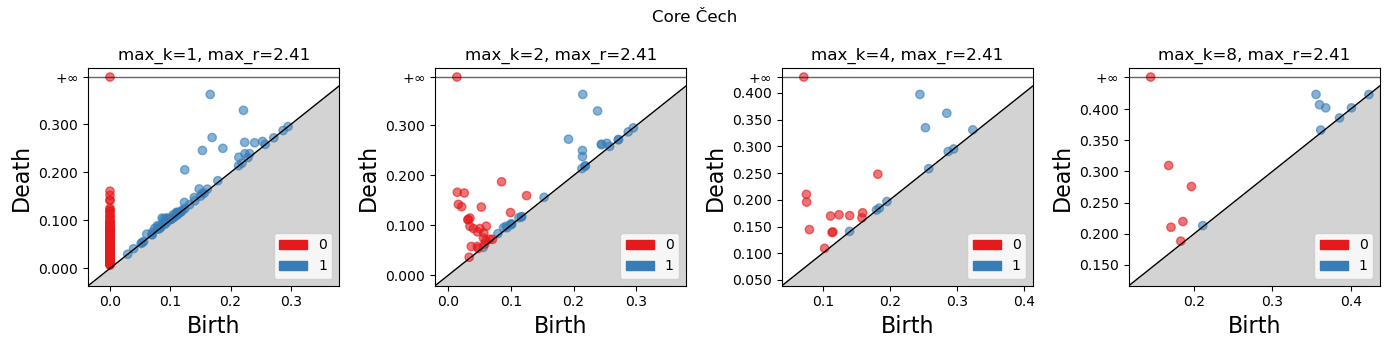

In [5]:
max_ks = [1, 2, 4, 8]
max_r = 2*math.sqrt(Miniball(X).squared_radius())

fig, axs = plt.subplots(ncols=len(max_ks), figsize=(14, 14 / len(max_ks)))
fig.suptitle("Core Čech")
for i, max_k in enumerate(max_ks):
    st_core = core_cech_slope(points=X, max_dim=2, max_k=max_k, max_r=max_r)
    gudhi.plot_persistence_diagram(st_core.persistence(), axes=axs[i])
    axs[i].set_title(f"max_k={max_k}, max_r={max_r:.2f}")
fig.tight_layout()
plt.show()

## Alpha Core

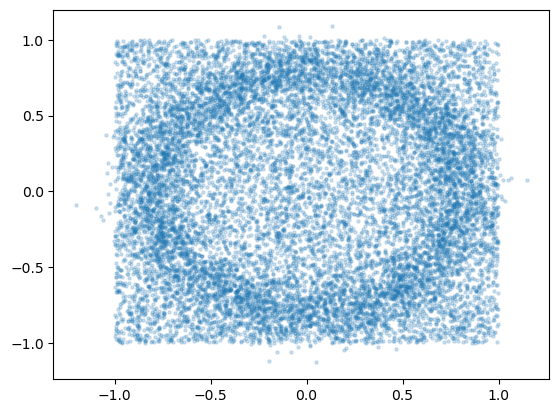

In [6]:
N = 5_000
M = 10_000
Z = sample_circle(N, rng, r=0.8, variance=0.01)
Y = sample_rectangle(M, rng)
X = np.r_[Z, Y]
plt.scatter(*X.T, s=5, alpha=0.2)
plt.show()

In [7]:
def alpha_core_slope(points, max_k=None, max_r=None):
    kd_tree = KDTree(points)
    k_core_distances, _ = kd_tree.query(points, k=max_k)
    line = np.linspace(max_r, 0, num=max_k)
    if max_k>1:
        vertex_indices = np.argmax(line <= k_core_distances, axis=1)
        vertex_values = k_core_distances[np.arange(len(k_core_distances)), vertex_indices]
    else:
        vertex_values = np.array(k_core_distances)
    st_alpha = gudhi.AlphaComplex(points=points).create_simplex_tree()
    for face, val in st_alpha.get_filtration():
        face_list = list(face)
        max_core = max(vertex_values[face_list])
        new_val = min(max(val ** 0.5, max_core), max_r)
        st_alpha.assign_filtration(face, new_val)
    return st_alpha

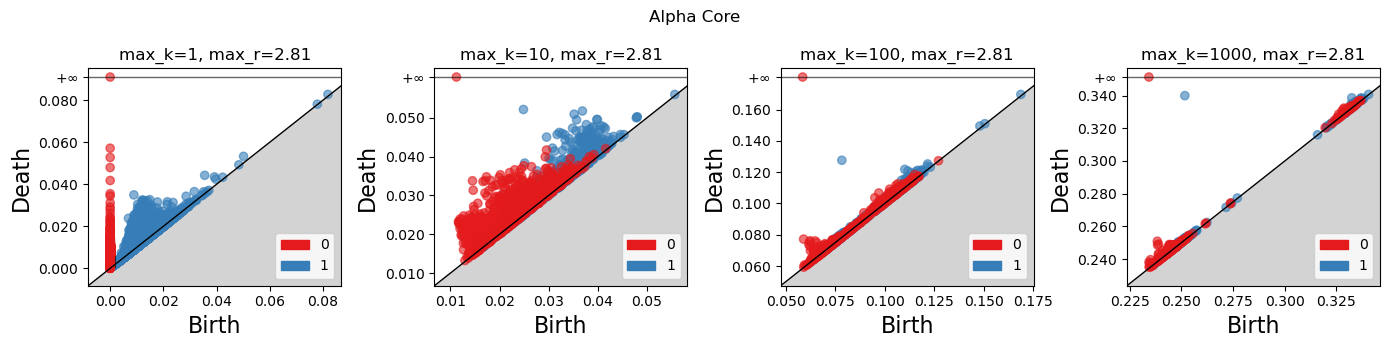

In [8]:
max_ks = [1, 10, 100, 1000]
max_r = 2*math.sqrt(Miniball(X).squared_radius())

fig, axs = plt.subplots(ncols=len(max_ks), figsize=(14, 14 / len(max_ks)))
fig.suptitle("Alpha Core")
for i, max_k in enumerate(max_ks):
    st_alpha_core = alpha_core_slope(points=X, max_k=max_k, max_r=max_r)
    gudhi.plot_persistence_diagram(st_alpha_core.persistence(), axes=axs[i])
    axs[i].set_title(f"max_k={max_k}, max_r={max_r:.2f}")
fig.tight_layout()
plt.show()